In [1]:
from functions import *

## Expectations

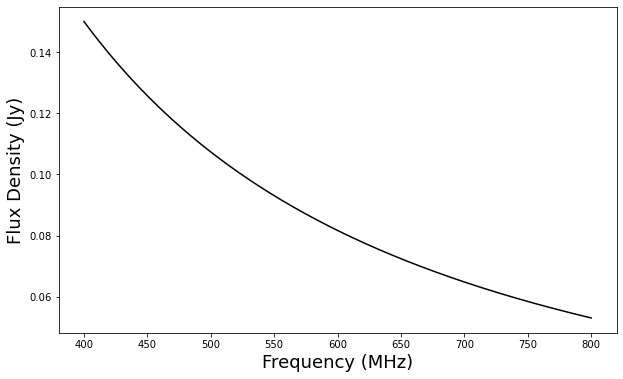

In [2]:
# Spectrum of the pulsar
freqs = np.linspace(800, 400, 1024)
pulsar_spectrum = flux_density(
    freqs, 
    ref_flux = 0.15,
    ref_freq = 400, 
    spectral_index = -1.5
)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs, pulsar_spectrum, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('Flux Density (Jy)', fontsize=18)
plt.show()

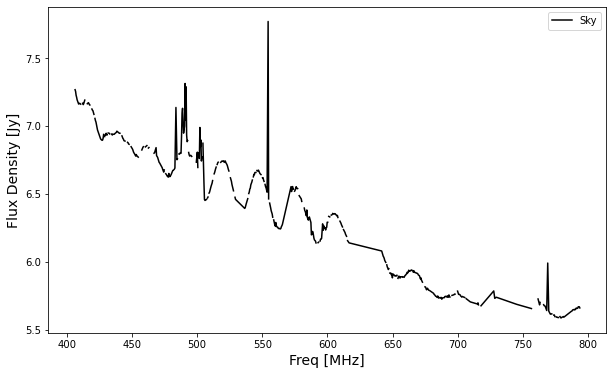

In [3]:
# Load average sky spectrum (SEFD)
sky_data = np.load("./data/calibrated_sky.npz")
sky_array = sky_data["array"]
sky_spectrum = sky_data["spectrum"]
sky_freq_mask = sky_data["freq_mask"]
df = sky_data["freq_bandwidth"]
dt = sky_data["sampling_time"]

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs[sky_freq_mask], 
    sky_spectrum[sky_freq_mask],
    color='black',
    label='Sky'
)
plt.ylabel('Flux Density [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.legend()
plt.show()

In [4]:
# Calibrator spectrum 
freqs = np.linspace(800, 400, 1024)
cal_spectrum = flux_density(freqs)

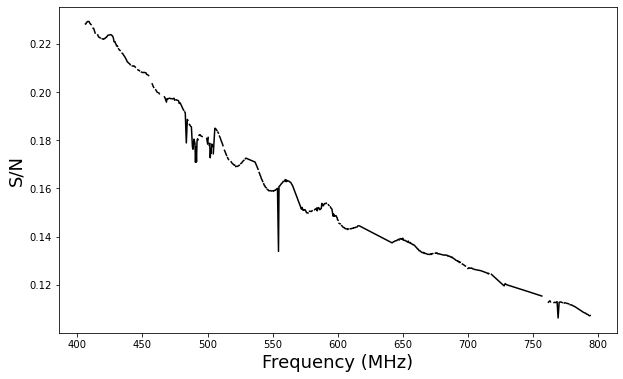

In [5]:
# Given that S/N is proportional to Sv/Ssys * sqrt(N)
N = 1
sn = pulsar_spectrum[sky_freq_mask]/ sky_spectrum[sky_freq_mask] * np.sqrt(dt* df* N)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs[sky_freq_mask], sn, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('S/N', fontsize=18)
plt.show()

In [6]:
sn_400_1 = sn[-1]
sn_desired = 2
N = np.power(sn_desired/ sn_400_1, 2)
print(f"Number of foldings required to achieve S/N 2: {N}")

Number of foldings required to achieve S/N 2: 77.98680664060242


## Load and Visulize Pulsar Data

Output()

Output()

Output()

Output()

Output()

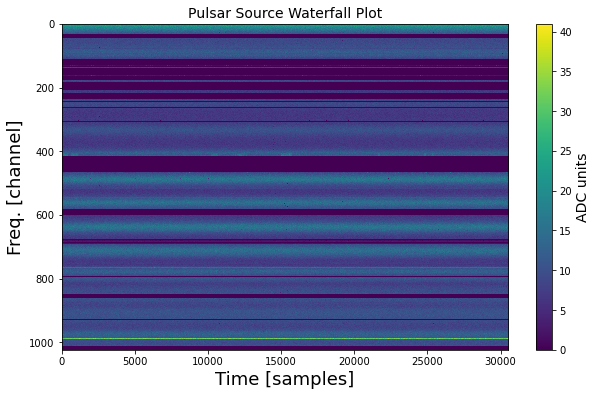

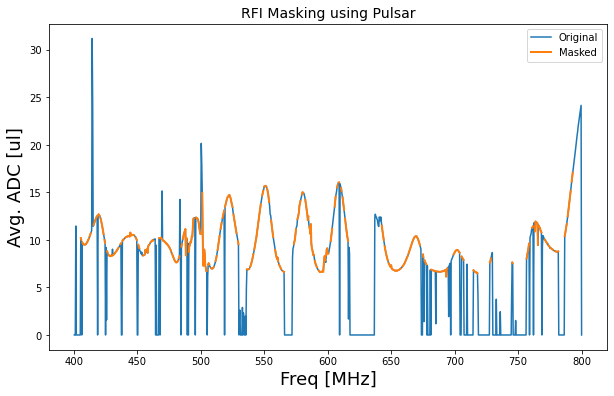

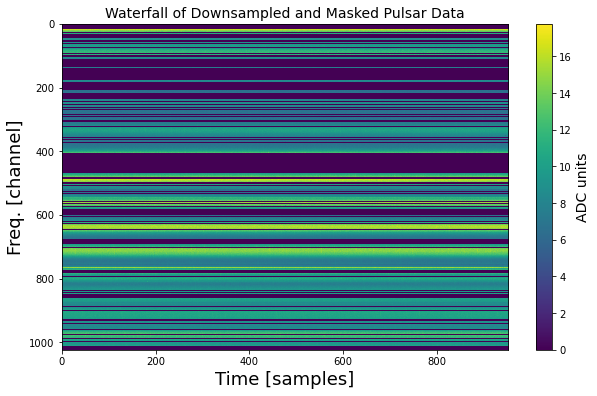

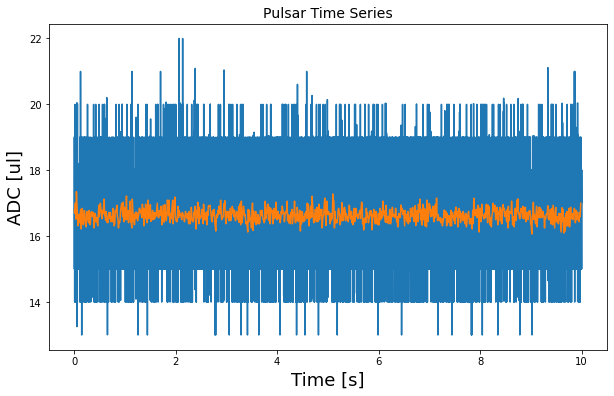

In [7]:
# Read in the data
pulsar = FilReader("./data/pulsardata.fil") 
Pretty(pulsar.header)

pulsar.compute_stats()
pulsar_data = pulsar.read_block(0, pulsar.header.nsamples, pulsar.header.fch1, pulsar.header.nchans)
pulsar_array = pulsar_data.data

# Mask the RFI
_, chan_mask = pulsar.clean_rfi(
    method = "mad",
    threshold=3, 
    outfile_name = "./data/pulsardata_masked.fil",
)
pulsar_masked = FilReader("./data/pulsardata_masked.fil") 
pulsar_masked.compute_stats()

freq_mask = pulsar_masked.chan_stats.mean == 0

# Downsample the data
pulsar_masked.downsample(
    tfactor = 32, 
    outfile_name = "./data/pulsardata_masked_f1_t32.fil"
)
pulsar_32 = FilReader("./data/pulsardata_masked_f1_t32.fil") 
pulsar_32.compute_stats()
pulsar_data_32 = pulsar_32.read_block(0, pulsar_32.header.nsamples, pulsar_32.header.fch1, pulsar_32.header.nchans)
pulsar_32_array = pulsar_data_32.data

# Plot the waterfall
fig = plt.figure(figsize=(10, 6))
im = plt.imshow(pulsar_array, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
plt.title('Pulsar Source Waterfall Plot', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Plot the mean spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(
    pulsar_masked.header.chan_freqs, 
    pulsar.chan_stats.mean, 
)
plt.plot(
    pulsar_masked.header.chan_freqs, 
    np.where(~freq_mask, pulsar_masked.chan_stats.mean, np.nan), 
    linewidth=2, 
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

# Waterfall of downsampled data
fig = plt.figure(figsize=(10, 6))
im = plt.imshow(pulsar_32_array,aspect='auto',interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
plt.title('Waterfall of Downsampled and Masked Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Timeseries
fig = plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(pulsar.header.nsamples) * pulsar.header.tsamp,
    pulsar_array[~freq_mask,:][1,:]
)
plt.plot(
    np.arange(pulsar_32.header.nsamples) * pulsar_32.header.tsamp,
    pulsar_32_array[~freq_mask,:][1,:]
)
plt.ylabel('ADC [ul]', fontsize=18)
plt.xlabel('Time [s]', fontsize=18)
plt.title('Pulsar Time Series', fontsize=14)
plt.show()

### Normalize pulsar data

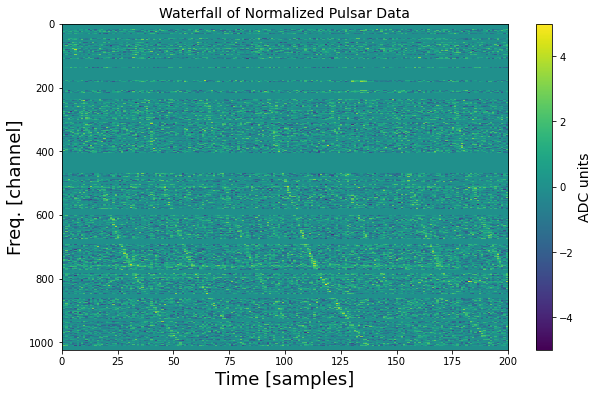

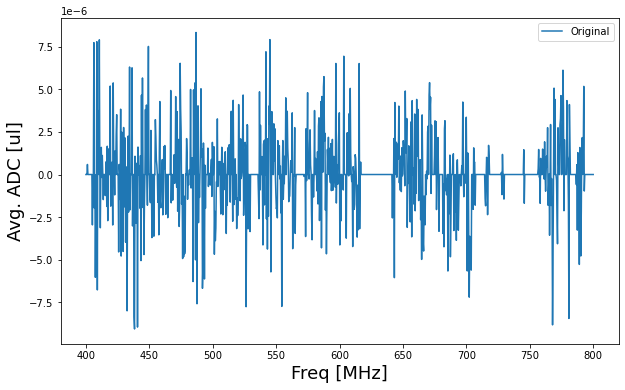

In [8]:
# Normalization
psr_normalized = normalize_data_per_channel(
    pulsar_32_array, 
    freq_mask,    
    invert_mask=True
)

fig = plt.figure(figsize=(10, 6))
im = plt.imshow(psr_normalized, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('ADC units', fontsize=14)
im.set_clim(-5, 5)
plt.title('Waterfall of Normalized Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.xlim(0, 200) 
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs, 
    np.mean(psr_normalized, axis=1)
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
# plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

## DM Search 

### Obtain the S/N as a function of DM and time

In [9]:
pulsar_data_32_dmt = pulsar_data_32.dmt_transform(50, dmsteps=100)
pulsar_data_32_dmt.dms

array([  0.      ,   1.010101,   2.020202,   3.030303,   4.040404,
         5.050505,   6.060606,   7.070707,   8.080808,   9.090909,
        10.10101 ,  11.111111,  12.121212,  13.131313,  14.141414,
        15.151515,  16.161615,  17.171717,  18.181818,  19.19192 ,
        20.20202 ,  21.212122,  22.222221,  23.232323,  24.242424,
        25.252525,  26.262627,  27.272728,  28.282827,  29.292929,
        30.30303 ,  31.313131,  32.32323 ,  33.333332,  34.343433,
        35.353535,  36.363636,  37.373737,  38.38384 ,  39.39394 ,
        40.40404 ,  41.414143,  42.424244,  43.434345,  44.444443,
        45.454544,  46.464645,  47.474747,  48.484848,  49.49495 ,
        50.50505 ,  51.515152,  52.525253,  53.535355,  54.545456,
        55.555557,  56.565655,  57.575756,  58.585857,  59.59596 ,
        60.60606 ,  61.61616 ,  62.626263,  63.636364,  64.64646 ,
        65.65656 ,  66.666664,  67.676765,  68.68687 ,  69.69697 ,
        70.70707 ,  71.71717 ,  72.72727 ,  73.73737 ,  74.747

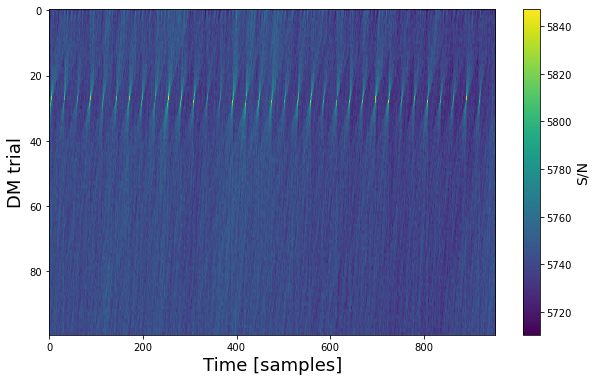

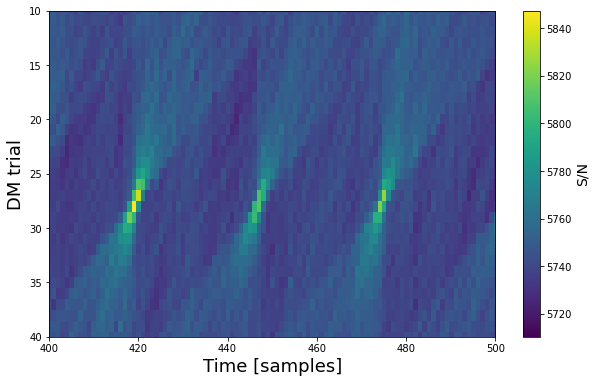

In [10]:
# print(pulsar_data_32_dmt.dms)
plt.figure(figsize=(10,6))
im = plt.imshow(pulsar_data_32_dmt.data, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
# plt.xlim(300,500)
# plt.ylim(25, 5)
plt.show()

plt.figure(figsize=(10,6))
im = plt.imshow(pulsar_data_32_dmt.data,aspect='auto',interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.xlim(400,500)
plt.ylim(40, 10)
plt.show()

### FFT of S/N(DM,t)

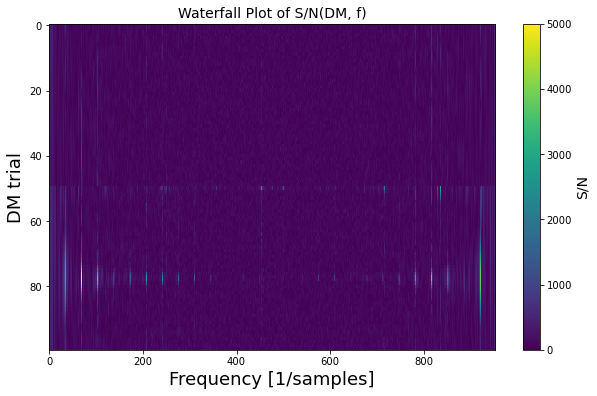

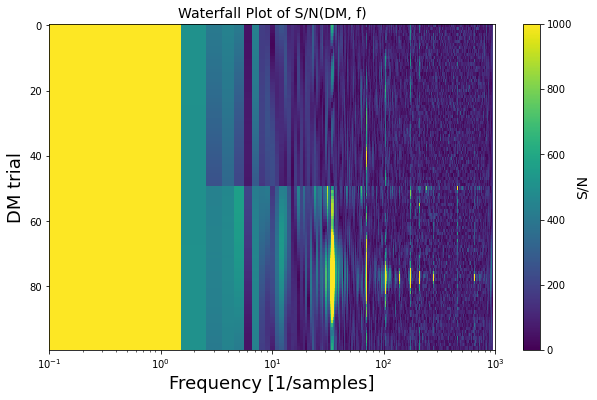

In [46]:
sn_dm_f = np.fft.fftshift(
    np.fft.fft(pulsar_data_32_dmt.data, axis=1),
    axes=0
)
num_time_samples = pulsar_data_32_dmt.data.shape[1]
fft_freqs = np.fft.fftfreq(num_time_samples)

# Plot the waterfall of S/N(DM, f)
plt.figure(figsize=(10, 6))
im = plt.imshow(
    np.abs(sn_dm_f), 
    aspect='auto', 
    interpolation='nearest',
    #extent=[freqs.min(), freqs.max(), 0, pulsar_data_32_dmt.data.shape[0]]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
im.set_clim(0, 5e3)
plt.xlabel('Frequency [1/samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.title('Waterfall Plot of S/N(DM, f)', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
im = plt.imshow(
    np.abs(sn_dm_f), 
    aspect='auto', 
    interpolation='nearest',
    #extent=[freqs.min(), freqs.max(), 0, pulsar_data_32_dmt.data.shape[0]]
)
cbar = plt.colorbar(im)
cbar.set_label("S/N", fontsize=14)
im.set_clim(0, 1e3)
# plt.ylim(0, 40)
plt.xlim(1e-1, 1e3)
plt.xscale('log')
plt.xlabel('Frequency [1/samples]', fontsize=18)
plt.ylabel('DM trial', fontsize=18)
plt.title('Waterfall Plot of S/N(DM, f)', fontsize=14)
plt.show()

### S/N maximizing DM and period

In [55]:
np.unravel_index(np.argmax(np.abs(sn_dm_f)), sn_dm_f.shape)

(38, 0)

In [60]:
# Find the max S/N
max_idx = np.unravel_index(np.argmax(np.abs(sn_dm_f)), sn_dm_f.shape)
max_dm_index, max_freq_index = max_idx

# Extract the corresponding DM and frequency
max_dm = pulsar_data_32_dmt.dms[max_dm_index]
max_freq = fft_freqs[max_freq_index+1]

# Convert frequency to period
max_period = 1 / max_freq if max_freq != 0 else np.inf
max_period = max_period * pulsar_data_32_dmt.header.tsamp

# Display results
print(
    f"Max S/N found at: DM = {max_dm}\n",
    f"Frequency = {max_freq}\n", 
    f"Period = {max_period}\n", 
    f"Sampling time = {pulsar_data_32_dmt.header.tsamp}"
)

Max S/N found at: DM = 38.38383865356445
 Frequency = 0.001049317943336831
 Period = 9.99292928
 Sampling time = 0.01048576


### Dedisperse

Output()

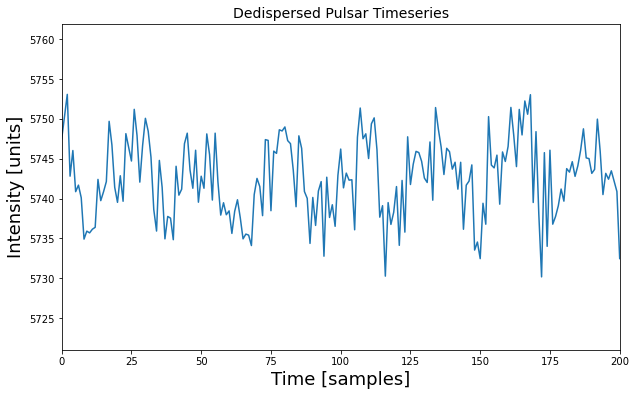

In [57]:
# Not used in the analysis
pulsar_32_dedisperse = pulsar_32.dedisperse(max_dm)

# Plot the dedispersed timeseries
plt.figure(figsize=(10, 6))
plt.plot(pulsar_32_dedisperse.data)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Intensity [units]', fontsize=18)
plt.title('Dedispersed Pulsar Timeseries', fontsize=14)
plt.xlim(0, 200)
plt.show()

## Folding 

Output()

/Users/namanjain/opt/anaconda3/lib/python3.9/site-packages/sigpyproc/base.py:1130: RuntimeWarning: invalid value encountered in true_divide
  fold_ar /= count_ar


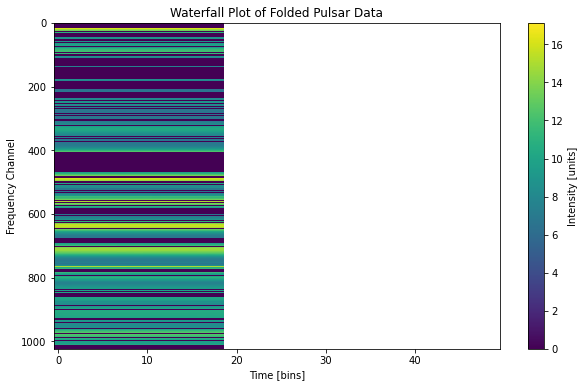

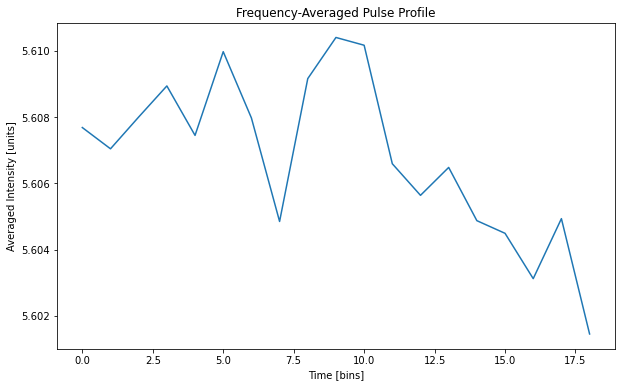

In [61]:
# Fold the pulsar data using the S/N maximizing parameters
pulsar_32_folded = pulsar_32.fold(
    period = 25, 
    dm = max_dm,
    nints = 1,  
    nbands = 1024,  
    # nbins = int(0.5 // pulsar_data_32.header.tsamp)  
)

# Plot the waterfall plot (2D folded pulse profile)
plt.figure(figsize=(10,6))
plt.imshow(pulsar_32_folded.data[0, :, :], aspect='auto', interpolation='nearest')
plt.colorbar(label='Intensity [units]')
plt.xlabel('Time [bins]')
plt.ylabel('Frequency Channel')
plt.title('Waterfall Plot of Folded Pulsar Data')
plt.show()

# Average over frequency channels to obtain the frequency-averaged pulse profile
pulse_profile = np.mean(pulsar_32_folded.data[0, :, :], axis=0)

# Plot the frequency-averaged pulse profile
plt.figure(figsize=(10,6))
plt.plot(pulse_profile)
plt.xlabel('Time [bins]')
plt.ylabel('Averaged Intensity [units]')
plt.title('Frequency-Averaged Pulse Profile')
plt.show()